# Tensorflow2.0 Implimentation of Image captioning System with visual attention and GTTS

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Methodology to Solve the Task

The task of image captioning can be divided into two modules logically – one is an image based model – which extracts the features and nuances out of our image, and the other is a language based model – which translates the features and objects given by our image based model to a natural sentence.

For our image based model (viz encoder) – we usually rely on a Convolutional Neural Network model. And for our language based model (viz decoder) – we rely on a Recurrent Neural Network. The image below summarizes the approach given above.




# Problem Statemtent

Image captioning is an interesting problem, where we can learn both computer vision techniques and natural language processing techniques. In case study I have followed [Show, Attend and Tell: Neural Image Caption
Generation with Visual Attention](https://arxiv.org/pdf/1502.03044.pdf) and create an image caption generation model using Flicker 8K data. This model takes a single image as input and output the caption to this image and read that predicted caption.

# Dependencies
* Python 3
* Tensorflow 2.0
* gtts

## Business Objectives and Constraints

*  Predict a correct caption as per the input image.
*  Incorrect caption could impact the negative impression on user.
*  No strict latency constraints.


## Mounting Google Drive locally

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.8.2


In [ ]:
import tensorflow as tf
#print(tensorflow.__version__)

In [ ]:
import matplotlib.pyplot as plt
# from keras.backend.tensorflow_backend import set_session
import keras
import sys, time, os, warnings 
import numpy as np
import pandas as pd 
from collections import Counter 
warnings.filterwarnings("ignore")

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import json
from glob import glob
from PIL import Image
import pickle



print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))


python 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
keras version 2.8.0
tensorflow version 2.8.2


## Data Overview

Flilckr8K contains 8,000 images that are each paired with five different captions which provide clear descriptions of the salient entities and events. The images were chosen from six different Flickr groups, and tend not to contain any well-known people or locations, but were manually selected to depict a variety of scenes and situations.

**Sources:**
* http://academictorrents.com/details/9dea07ba660a722ae1008c4c8afdd303b6f6e53b
* https://forms.illinois.edu/sec/1713398

> Flickr8k_Dataset: Contains all the  images

> Flickr8k_text: Contains all the captions

In [ ]:
## The location of the Flickr8K_ photos
dir_Flickr_jpg = "/content/drive/MyDrive/Caption_data/flickr8k/Images"
## The location of the caption file
dir_Flickr_text = "/content/drive/MyDrive/Caption_data/flickr8k/captions.txt"

jpgs = os.listdir(dir_Flickr_jpg)
print("The number of jpg flies in Flicker8k: {}".format(len(jpgs)))

## Mapping the real-world problem to a Deep Learning Problem

To accomplish this, we'll use an attention-based model, which enables us to see what parts of the image the model focuses on as it generates a caption.
“**Show, Attend and Tell: Neural Image Caption Generation with Visual Attention**” by Xu et al. (2015) — the first paper, to our knowledge, that introduced the concept of attention into image captioning. The work takes inspiration from attention’s application in other sequence and image recognition problems.

# Key Performance Indicator (KPI)

As per the [Research paper](https://www.aclweb.org/anthology/P02-1040.pdf):

The primary programming task for a BLEU implementor is to compare n-grams of the candidate with the n-grams of the reference translation and count the number of matches. These matches are position-independent. The more the matches, the better the candidate translation is. 

BLEU is a well-acknowledged metric to measure the similarly of one hypothesis sentence to multiple reference sentences.
Given a single hypothesis sentence and multiple reference sentences, it returns value between 0 and 1.

The metric close to 1 means that the two are very similar. 
The metric was introduced in 2002 BLEU: a Method for Automatic Evaluation of Machine Translation. Although there are many problems in this metric, for example grammatical correctness are not taken into account, BLEU is very well accepted partly because it is easy to calculate.

*  Higher the score better the quality of caption

## [2] Exploratory Data Analysis

Import caption data

Load the text data and save it into a panda dataframe data.

* filename : jpg file name
* index : unique ID for each caption for the same image
* caption : string of caption, all in lower case

In [ ]:
## read in the Flickr caption data
# file = open(dir_Flickr_text,'r')
# text = file.read()
# file.close()
with open(dir_Flickr_text,'r') as f:
  text = f.read()
print(text)

datatxt = []
for line in text.split('\n'):
    col = line.split(',')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

data = pd.DataFrame(datatxt,columns=["filename","caption"])


uni_filenames = np.unique(data.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(data.filename.values).values())

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Counter({1: 1, 5: 8091})

In [ ]:
data.drop(0,inplace = True)

In [ ]:
data = data.reset_index()
data.drop('index',axis = 1,inplace = True)

In [ ]:
data.head(10)

,filename,caption
0,1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,a girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,a black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,a black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,a black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,two dogs on pavement moving toward each other .


In [ ]:
data['index'] = 0

In [ ]:
data.head(10)

,filename,caption,index
0,1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...,0
1,1000268201_693b08cb0e.jpg,a girl going into a wooden building .,0
2,1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .,0
3,1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...,0
4,1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...,0
5,1001773457_577c3a7d70.jpg,a black dog and a spotted dog are fighting,0
6,1001773457_577c3a7d70.jpg,a black dog and a tri-colored dog playing with...,0
7,1001773457_577c3a7d70.jpg,a black dog and a white dog with brown spots a...,0
8,1001773457_577c3a7d70.jpg,two dogs of different breeds looking at each o...,0
9,1001773457_577c3a7d70.jpg,two dogs on pavement moving toward each other .,0


In [ ]:
index = 0
first = True
data['index'] = 0
for i in range(len(data)):
  filename = data.loc[i]['filename']
  occurences = list_filename[:i+1].count(filename)
  data.at[i,'index'] = occurences - 1

In [ ]:
data.head(10)

,filename,caption,index
0,1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...,0
1,1000268201_693b08cb0e.jpg,a girl going into a wooden building .,1
2,1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .,2
3,1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...,3
4,1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...,4
5,1001773457_577c3a7d70.jpg,a black dog and a spotted dog are fighting,0
6,1001773457_577c3a7d70.jpg,a black dog and a tri-colored dog playing with...,1
7,1001773457_577c3a7d70.jpg,a black dog and a white dog with brown spots a...,2
8,1001773457_577c3a7d70.jpg,two dogs of different breeds looking at each o...,3
9,1001773457_577c3a7d70.jpg,two dogs on pavement moving toward each other .,4


### Let's have a look at some of the pictures together with the captions.

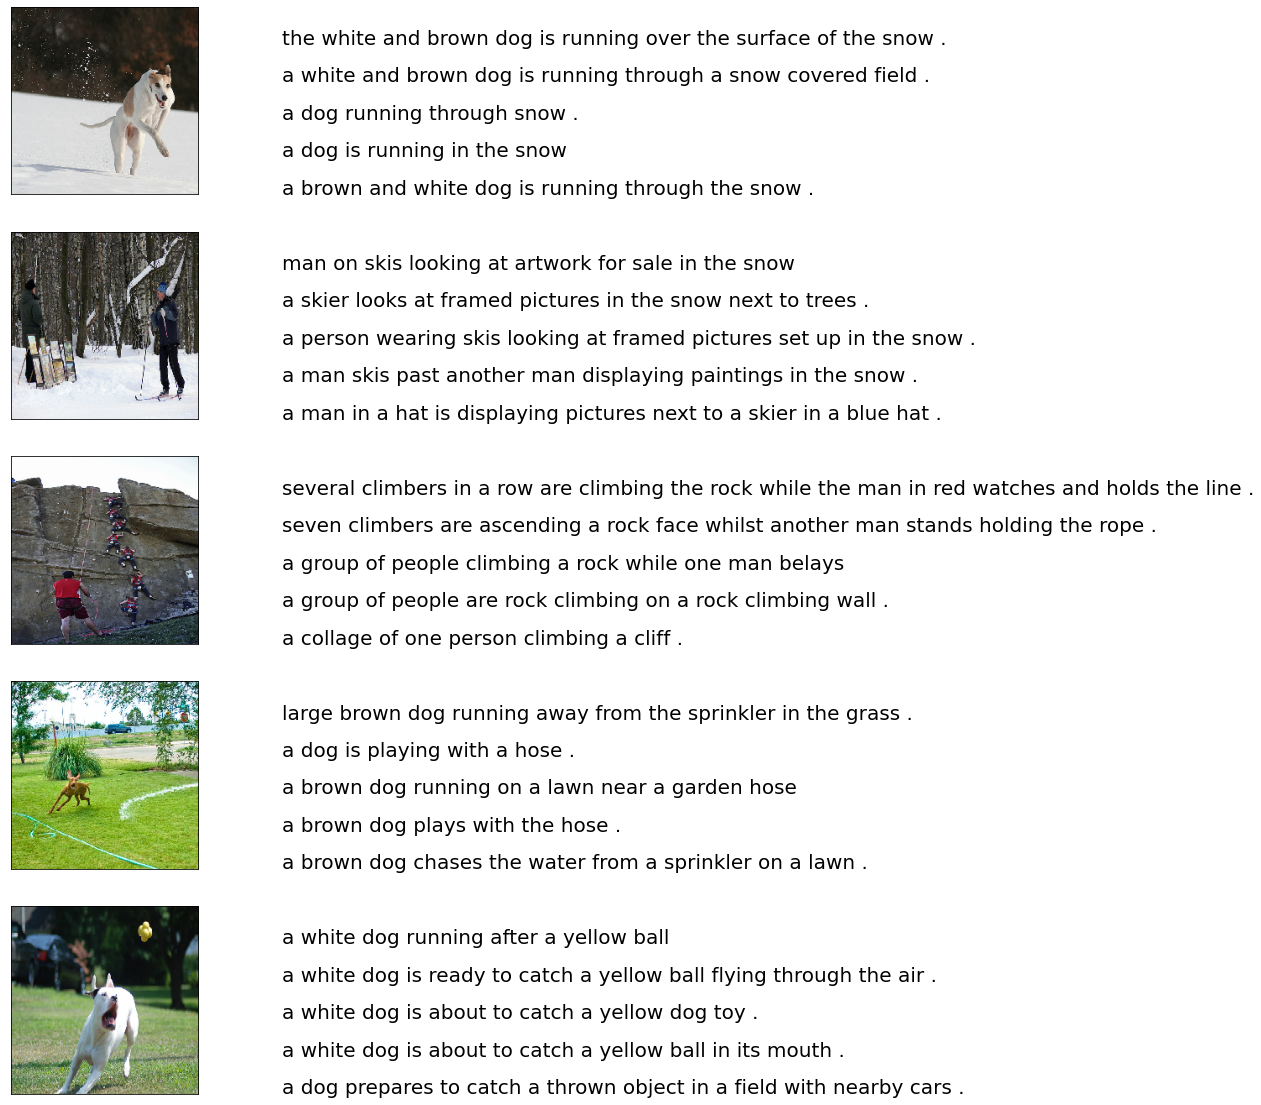

In [ ]:
from keras.preprocessing.image import load_img, img_to_array

npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[10:15]:
    filename = dir_Flickr_jpg + '/' + jpgfnm
    captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

### Observation:
* For each image there are 5 distinct captions
* Some sentences finish with "." but not all.

#  [3] Preprocessing




### [3.1] Images

Let's check if there are any unvalid image!

In [ ]:
#https://www.mkyong.com/regular-expressions/how-to-validate-image-file-extension-with-regular-expression/
import re
for i in data["filename"]:
    x = re.search("([^\s]+(\.(?i)(jpg|png|gif|bmp))$)", i)
    if (x):
        pass
    else:
        print(f"YES! We have a match!: {i}")

In [ ]:
data.shape

(40455, 3)

In [ ]:
# data.loc[data['filename'] == "2258277193_586949ec62.jpg.1"]

In [ ]:
# data = data[data.filename != '2258277193_586949ec62.jpg.1']

In [ ]:
data.shape

(40455, 3)

### [3.2] Captions

In [ ]:
def df_word(data):
    vocabulary = []
    for txt in data.caption.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    appen_1 = []
    appen_2 = []
    for i in ct.keys():
        appen_1.append(i)
    for j in ct.values():
        appen_2.append(j)
    data = {"word":appen_1 , "count":appen_2}
    dfword = pd.DataFrame(data)
    dfword = dfword.sort_values(by='count', ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
dfword = df_word(data)

Vocabulary Size: 8871


In [ ]:
dfword.head(10)

,word,count
0,a,60196
1,.,34205
2,in,18174
3,the,17507
4,on,10357
5,is,9069
6,and,8057
7,dog,7948
8,with,7304
9,man,7137


In [ ]:
dfword.tail(10)

,word,count
8861,suspension,1
8862,seater,1
8863,sightseeing,1
8864,needlepoint,1
8865,tending,1
8866,abarrotes,1
8867,brought,1
8868,wetsuite,1
8869,steeple,1
8870,patterns,1


In [ ]:
data.caption.values

array(['a child in a pink dress is climbing up a set of stairs in an entry way .',
       'a girl going into a wooden building .',
       'a little girl climbing into a wooden playhouse .', ...,
       'a person in a red shirt climbing up a rock face covered in assist handles .',
       'a rock climber in a red shirt .',
       'a rock climber practices on a rock climbing wall .'], dtype=object)

In [ ]:
vocabulary = []
for txt in data.caption.values:
    vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))
ct = Counter(vocabulary)
ct.keys()

Vocabulary Size: 8871


dict_keys(['a', 'child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'an', 'entry', 'way', '.', 'girl', 'going', 'into', 'wooden', 'building', 'little', 'playhouse', 'the', 'to', 'her', 'cabin', 'black', 'dog', 'and', 'spotted', 'are', 'fighting', 'tri-colored', 'playing', 'with', 'each', 'other', 'on', 'road', 'white', 'brown', 'spots', 'staring', 'at', 'street', 'two', 'dogs', 'different', 'breeds', 'looking', 'pavement', 'moving', 'toward', 'covered', 'paint', 'sits', 'front', 'painted', 'rainbow', 'hands', 'bowl', 'sitting', 'large', 'small', 'grass', 'plays', 'fingerpaints', 'canvas', 'it', 'there', 'pigtails', 'painting', 'young', 'outside', 'man', 'lays', 'bench', 'while', 'his', 'by', 'him', 'which', 'also', 'tied', 'sleeping', 'next', 'shirtless', 'lies', 'park', 'laying', 'holding', 'leash', 'ground', 'orange', 'hat', 'starring', 'something', 'wears', 'glasses', 'gauges', 'wearing', 'blitz', 'beer', 'can', 'crocheted', 'pierced', 'ears', 'rope', 'net

## The most and least frequently appearing words
The most common words are articles such as "a", or "the", or punctuations.

These words do not have much infomation about the data.

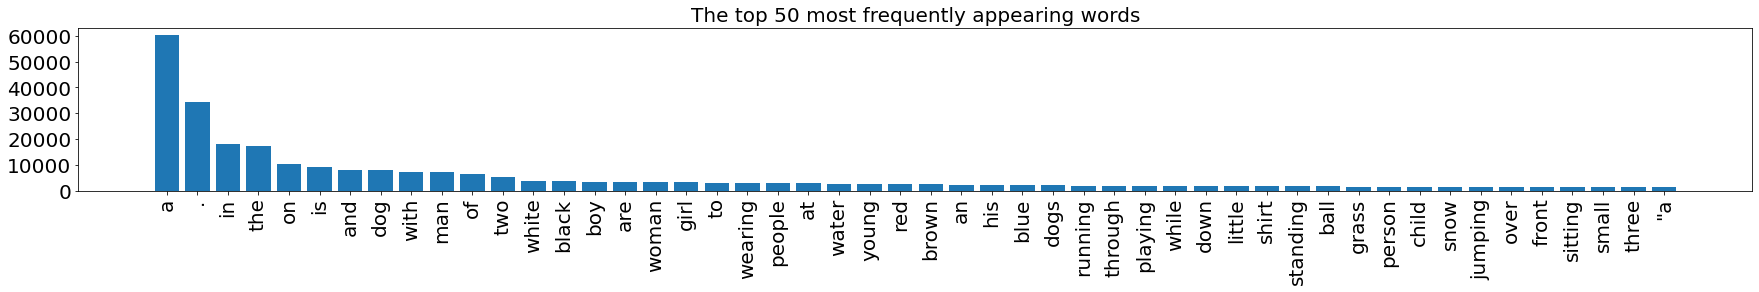

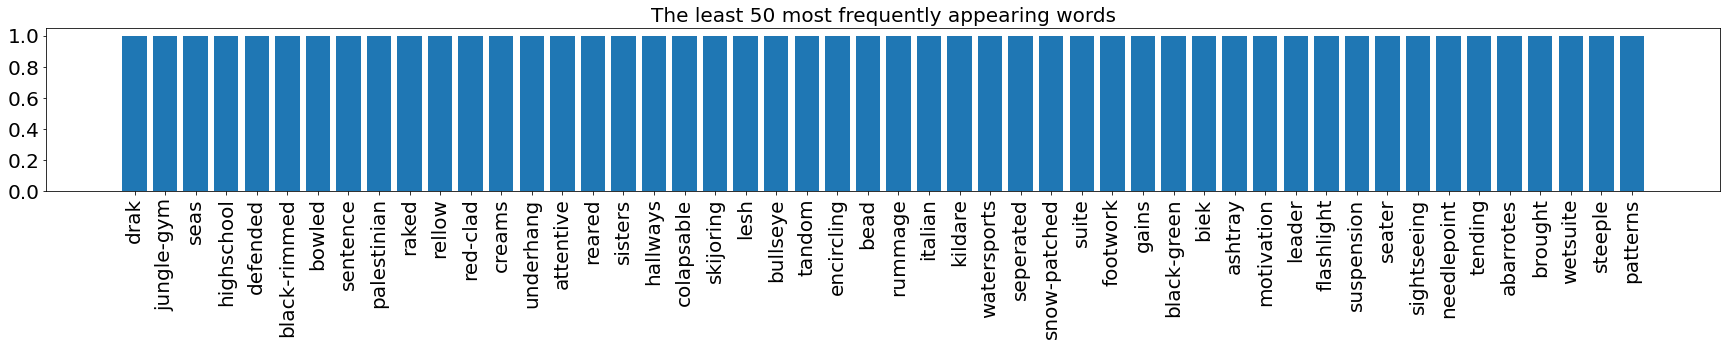

In [ ]:
topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(30,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

Check Image shape:

In [ ]:
# img1= plt.imread("/content/gdrive/My Drive/Image Cap/Flickr8k_Dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg")
# plt.imshow(img1)
# print(f"Shape of the image: {img1.shape}")

In [ ]:
#make a list of images and caption
img = data["filename"].tolist()
caption = data["caption"].tolist()

In [ ]:
print(f"len(img) : {len(img)}")
print(f"len(caption) : {len(caption)}")

len(img) : 40455
len(caption) : 40455


In [ ]:
#Distinct images an Captions
print(f"Total Unique imgs : {len(set(img))}")
print(f"total unique captions : {len(set(caption))}")

Total Unique imgs : 8091
total unique captions : 39890


We prepare text and image data separately.

In [ ]:
data.head()

,filename,caption,index
0,1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...,0
1,1000268201_693b08cb0e.jpg,a girl going into a wooden building .,1
2,1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .,2
3,1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...,3
4,1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...,4


## Add start and end sequence tokens

Usually, a pretrained CNN extracts the features from our input image. The feature vector is linearly transformed to have the same dimension as the input dimension of the RNN/GRU network. This network is trained as a language model on our feature vector.

For training our GRU model, we predefine our label and target text. For example, if the caption is “A man and a girl sit on the ground and eat.”, our label and target would be as follows –

Label – [<start<start>>, A,  man,  and,  a, girl,  sit,  on,  the,  ground,  and,  eat,  <end<start>> ] 
    
Target – [ A, man,  and,  a,  girl,  sit,  on,  the,  ground,  and,  eat,  ., <<end>> ]

This is done so that our model understands the start and end of our labelled sequence.

In [ ]:
#Add start and end sequence tokens
PATH = "/content/drive/MyDrive/Caption_data/flickr8k/Images/"
all_captions = []

for caption  in data["caption"].astype(str):
    caption = '<start> ' + caption+ ' <end>'
    all_captions.append(caption)
all_captions[:10]

['<start> a child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> a girl going into a wooden building . <end>',
 '<start> a little girl climbing into a wooden playhouse . <end>',
 '<start> a little girl climbing the stairs to her playhouse . <end>',
 '<start> a little girl in a pink dress going into a wooden cabin . <end>',
 '<start> a black dog and a spotted dog are fighting <end>',
 '<start> a black dog and a tri-colored dog playing with each other on the road . <end>',
 '<start> a black dog and a white dog with brown spots are staring at each other in the street . <end>',
 '<start> two dogs of different breeds looking at each other on the road . <end>',
 '<start> two dogs on pavement moving toward each other . <end>']

In [ ]:
all_img_name_vector = []

for annot in data["filename"]:
    full_image_path = PATH + annot

    all_img_name_vector.append(full_image_path)
all_img_name_vector[:10]

['/content/drive/MyDrive/Caption_data/flickr8k/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/Caption_data/flickr8k/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/Caption_data/flickr8k/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/Caption_data/flickr8k/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/Caption_data/flickr8k/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/Caption_data/flickr8k/Images/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/Caption_data/flickr8k/Images/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/Caption_data/flickr8k/Images/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/Caption_data/flickr8k/Images/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/Caption_data/flickr8k/Images/1001773457_577c3a7d70.jpg']

In [ ]:
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")

len(all_img_name_vector) : 40455
len(all_captions) : 40455


## limitting the size of the training set 
We'll use a subset of 40,000 captions and their corresponding images to train our model.

In [ ]:
# Shuffle captions and image_names together
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

In [ ]:
# Select the first 40000 captions from the shuffled set
num_examples = 40000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]
print(f"priviously we had {len(all_captions)} captions, and Now we have {len(train_captions)}.")

priviously we had 40455 captions, and Now we have 40000.


In [ ]:
len(img_name_vector)

40000

In [ ]:
%cd /content/drive/MyDrive/Caption_data

/content/drive/MyDrive/Caption_data


In [ ]:
!mkdir train_captions
!mkdir img_name_vector

mkdir: cannot create directory ‘train_captions’: File exists
mkdir: cannot create directory ‘img_name_vector’: File exists


In [ ]:
dbfile1 = open('/content/drive/MyDrive/Caption_data/train_captions.pkg', 'ab')   
dbfile2 = open('/content/drive/MyDrive/Caption_data/img_name_vector.pkg', 'ab')    

pickle.dump(train_captions, dbfile1)   
pickle.dump(img_name_vector, dbfile2)                    
dbfile1.close() 
dbfile2.close() 


## Preprocess the images using VGG16
Next, we will use VGG16 (which is pretrained on Imagenet) to classify each image. Create features for each image using VGG16's pre-trained networks.
We will extract features from the last convolutional layer.

First, we will convert the images into VGG16's expected format by:
* Resizing the image to 224*224px

In [ ]:
from keras.applications.vgg16 import VGG16, preprocess_input

In [ ]:

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = preprocess_input(img)
    return img, image_path

## Initialize VGG16 and load the pretrained Imagenet weights


* As I am not using VGG16 for the sake of the classification but I just need it for extracting features, I will remove the last layer from the network.
* We forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).

In [ ]:
image_model = tf.keras.applications.VGG16(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
image_features_extract_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

## Features extractraction from VGG16

 


In [ ]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

print(f"Let's check the BatchDataset shapes--> {image_dataset}")

Let's check the BatchDataset shapes--> <BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>


In [ ]:
from tqdm import tqdm

In [ ]:

%%time
for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

In [ ]:
bf.numpy().shape

(49, 512)

In [ ]:
print(batch_features.numpy().shape)

(64, 49, 512)


## Preprocess and tokenize the captions

* First, we'll tokenize the captions (for example, by splitting on spaces). This gives us a  vocabulary of all of the unique words in the data (for example, "surfing", "football", and so on).
* Next, we'll limit the vocabulary size to the top 5,000 words (to save memory)
* You then create word-to-index and index-to-word mappings.
* Finally, we pad all sequences to be the same length as the longest one.

In [ ]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)


tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'


# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')


print(cap_vector.shape)

(40000, 35)


## Split the data into training and testing

In [ ]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)


# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(32000, 32000, 8000, 8000)

In [ ]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 512
attention_features_shape = 49

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap


dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Model

* In this example, you extract the features from the lower convolutional layer of VGG16 giving us a vector of shape (224, 224, 3).
* Then squash that to a shape of (64, 512).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
# encoder.summary()

In [ ]:
# decoder.summary()

In [ ]:
max_length

35

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Saving Checkpoint
* TensorFlow objects provide an easy automatic mechanism for saving and restoring the values of variables they use.
* All prefixes are grouped together in a single checkpoint file ('./tf_ckpts/checkpoint') where the CheckpointManager saves its state.

In [ ]:
checkpoint_path_ckpt = "./checkpoint_final/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path_ckpt, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

## Training

* Now we extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
> Teacher forcing is a method for quickly and efficiently training recurrent neural network models that use the ground truth from a prior time step as input.
Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [ ]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

  return loss, total_loss

In [ ]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.8234
Epoch 1 Batch 100 Loss 1.5656
Epoch 1 Batch 200 Loss 1.3834
Epoch 1 Batch 300 Loss 1.2649
Epoch 1 Batch 400 Loss 1.2013
Epoch 1 Loss 1.408316
Time taken for 1 epoch 126.37285256385803 sec

Epoch 2 Batch 0 Loss 1.1279
Epoch 2 Batch 100 Loss 1.0423
Epoch 2 Batch 200 Loss 1.0447
Epoch 2 Batch 300 Loss 1.1292
Epoch 2 Batch 400 Loss 0.9272
Epoch 2 Loss 1.066084
Time taken for 1 epoch 75.93377542495728 sec

Epoch 3 Batch 0 Loss 0.9214
Epoch 3 Batch 100 Loss 0.9682
Epoch 3 Batch 200 Loss 0.9744
Epoch 3 Batch 300 Loss 1.0149
Epoch 3 Batch 400 Loss 0.8819
Epoch 3 Loss 0.959458
Time taken for 1 epoch 74.19384503364563 sec

Epoch 4 Batch 0 Loss 0.9123
Epoch 4 Batch 100 Loss 0.9435
Epoch 4 Batch 200 Loss 0.8911
Epoch 4 Batch 300 Loss 0.8718
Epoch 4 Batch 400 Loss 0.8361
Epoch 4 Loss 0.883372
Time taken for 1 epoch 76.02978777885437 sec

Epoch 5 Batch 0 Loss 0.8600
Epoch 5 Batch 100 Loss 0.9251
Epoch 5 Batch 200 Loss 0.7893
Epoch 5 Batch 300 Loss 0.8141
Epoch 5 Batch 400

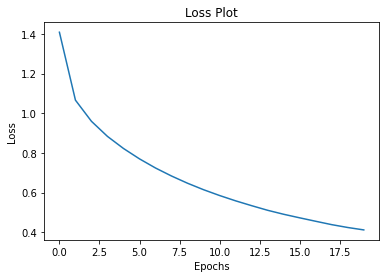

In [ ]:

plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption!

* The evaluate function is similar to the training loop, except we don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

## captions on the validation set

Real Caption: <start> a scruffy golden dog meeting a black doberman in the snow <end>
Prediction Caption: two dogs are standing in the snow <end>


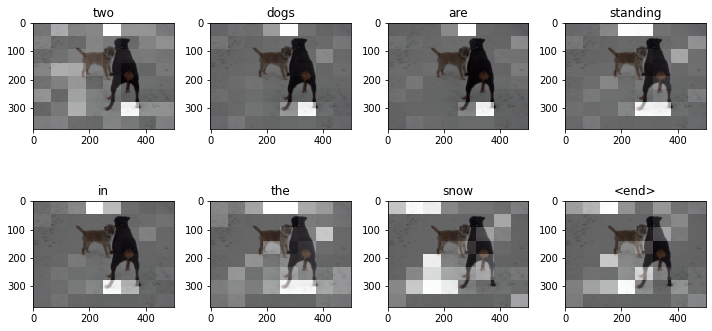

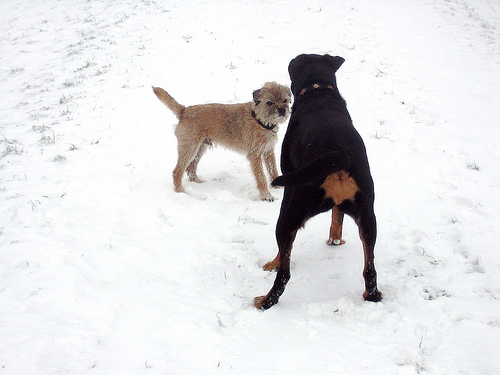

In [ ]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

for i in result:
    if i=="<unk>":
        result.remove(i)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
# opening the image
Image.open(img_name_val[rid])

Real Caption: <start> a woman takes a picture as it snows <end>
Prediction Caption: a woman in a white hat is aiming her camera <end>


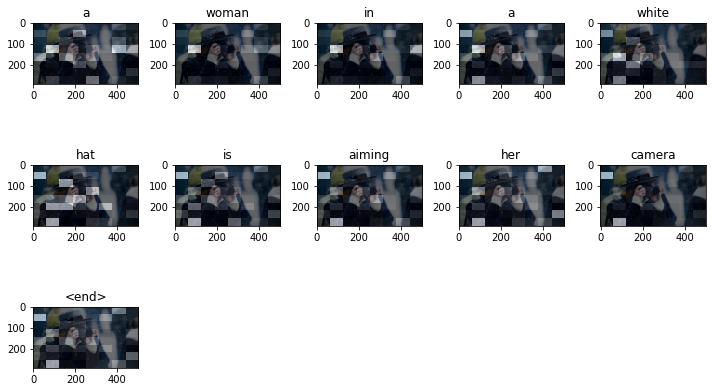

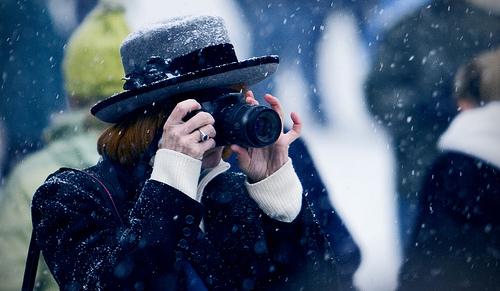

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
# opening the image
Image.open(img_name_val[rid])

## Bilingual evaluation understudy (BLEU)

* Filter the <unk<k>> from sentences
* drop the <start> and <end> from sentences
* Compute the 2-gram BLEU score


In [ ]:
#Example
# n-gram individual BLEU
from nltk.translate.bleu_score import sentence_bleu
reference = [['this', 'a', 'test','of', 'cricket', 'match']]
candidate = ['this', 'is', 'a', 'test','of', 'cricket', 'match']
print('Individual 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Individual 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 1, 0, 0)))
print('Individual 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 1, 0)))
print('Individual 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 0, 1)))

In [ ]:
# captions on the validation set


# longer candidate
from nltk.translate.bleu_score import sentence_bleu

rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]

start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)


first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
    if i=="<unk>":
        result.remove(i)


#remove <end> from result         
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final
score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

print(f"time took to Predict: {round(time.time()-start)} sec")
# opening the image
Image.open(img_name_val[rid])

In [ ]:
# captions on the validation set


# longer candidate
from nltk.translate.bleu_score import sentence_bleu

rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]

start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)


first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
    if i=="<unk>":
        result.remove(i)


#remove <end> from result         
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final
score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

print(f"time took to Predict: {round(time.time()-start)} sec")
# opening the image
Image.open(img_name_val[rid])

In [ ]:
# captions on the validation set


# longer candidate
from nltk.translate.bleu_score import sentence_bleu

rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]

start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)


first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
    if i=="<unk>":
        result.remove(i)


#remove <end> from result         
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final
score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

print(f"time took to Predict: {round(time.time()-start)} sec")
# opening the image
Image.open(img_name_val[rid])

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_caption
first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
    if i=="<unk>":
        result.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result         
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result
score = sentence_bleu(reference, candidate)
print(f"BELU score: {score*100}")


print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)


# opening the image
IMG(img_name_val[rid])

tts = gTTS(result_final) #Provide the string to convert to speech
tts.save('1.wav') #save the string converted to speech as a .wav file
sound_file = '1.wav'
Audio(sound_file, autoplay=True) 


# Caption on Unseen images

In [ ]:
image_url = 'http://www.bhamgov.org/DPS/Dog_Running.jpg'
image_extension = image_url[-3:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

###Predict

In [5]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
!git clone https://github.com/ishritam/Image-captioning-with-visual-attention

Cloning into 'Image-captioning-with-visual-attention'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 18 (delta 6), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (18/18), done.


In [6]:
%cd Image-captioning-with-visual-attention

/content/drive/MyDrive/Image-captioning-with-visual-attention


In [7]:
!pip install gtts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from image_cap import *


In [8]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:


get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
# from keras.backend.tensorflow_backend import set_session
import keras
import tensorflow as tf
import sys, time, os, warnings 
import numpy as np
import pandas as pd 
from collections import Counter 
import warnings
warnings.filterwarnings("ignore")


import logging #Disable Tensorflow debugging information
tf.get_logger().setLevel(logging.ERROR)

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import json
from glob import glob
from PIL import Image
import pickle

from PIL import Image
import requests
import time

from gtts import gTTS #Import Google Text to Speech
from IPython.display import Audio #Import Audio method from IPython's Display Class
from keras.applications.vgg16 import VGG16, preprocess_input


def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = preprocess_input(img)
    return img, image_path

image_model = tf.keras.applications.VGG16(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
#image_features_extract_model.summary()	


# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

	
BATCH_SIZE = 64
BUFFER_SIZE = 1000
max_length = 39
embedding_dim = 256
units = 512
vocab_size = 8291
features_shape = 512
attention_features_shape = 49
	
	
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 64, 1)
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


# In[25]:


class CNN_Encoder(tf.keras.Model):
	# Since you have already extracted the features and dumped it using pickle
	# This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
		# shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x


class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))


# In[27]:


encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, 8291)


# In[28]:


optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)



# In[32]:


def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

def image_plot(image):
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    img=mpimg.imread(image)
    imgplot = plt.imshow(img)
    plt.show()
    '''from PIL import Image
    import requests

    return Image.open(requests.get(image, stream=True).raw)
    '''
def voice(res):
    tts = gTTS(' '.join(res).rsplit(' ', 1)[0]) #Provide the string to convert to speech
    tts.save('1.mp3')#save the string converted to speech as a .wav file
    sound_file = './1.mp3'
    return Audio(sound_file, autoplay=True) 




58900480/58889256 [==============================] - 0s 0us/step


In [9]:
def predict(train_captions_path, checkpoint_path, Image_path ):
    dbfile = open(train_captions_path, 'rb')      
    train_captions = pickle.load(dbfile)  
    dbfile.close() 


    # Choose the top 5000 words from the vocabulary
    top_k = 5000
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                      oov_token="<unk>",
                                                      filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
    tokenizer.fit_on_texts(train_captions)
    train_seqs = tokenizer.texts_to_sequences(train_captions)


    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'


    # Create the tokenized vectors
    train_seqs = tokenizer.texts_to_sequences(train_captions)

    # Pad each vector to the max_length of the captions
    # If you do not provide a max_length value, pad_sequences calculates it automatically
    cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')


    # Calculates the max_length, which is used to store the attention weights
    max_length = calc_max_length(train_seqs)


    #restoring the model
    checkpoint_path = checkpoint_path
    #tf.compat.v2.keras.callbacks.ModelCheckpoint
    ckpt = tf.train.Checkpoint(encoder=encoder,
                               decoder=decoder,
                               optimizer = optimizer)
    ckpt.restore(checkpoint_path)

    
    def evaluate(image):
        attention_plot = np.zeros((max_length, attention_features_shape))

        hidden = decoder.reset_state(batch_size=1)
        temp_input = tf.expand_dims(load_image(image)[0], 0)
        img_tensor_val = image_features_extract_model(temp_input)
        img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

        features = encoder(img_tensor_val)

        dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
        result = []

        for i in range(max_length):
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

            predicted_id = tf.argmax(predictions[0]).numpy()
            result.append(tokenizer.index_word[predicted_id])

            if tokenizer.index_word[predicted_id] == '<end>':
                return result, attention_plot

            dec_input = tf.expand_dims([predicted_id], 0)

        attention_plot = attention_plot[:len(result), :]
        return result, attention_plot

    
    new_img =  Image_path

    result, attention_plot = evaluate(new_img)
    for i in result:
        if i=="<unk>":
            result.remove(i)
        else:
            pass
    
    print('I guess: ', ' '.join(result).rsplit(' ', 1)[0])

    #real_caption = ' '.join(result).rsplit(' ', 1)[0]
    plot_attention(new_img, result, attention_plot)
    
    image_plot(new_img)
    
    return result
    

In [18]:
import spacy
nlp = spacy.load("en_core_web_sm")



In [10]:
list_img = ['/content/drive/MyDrive/Caption_data/flickr8k/Images/3711611500_ea47b58b6f.jpg','/content/drive/MyDrive/Caption_data/flickr8k/dogwater2.jfif','/content/drive/MyDrive/Caption_data/flickr8k/dogongrass1.jfif','/content/drive/MyDrive/Caption_data/flickr8k/dogongrass2.jfif']

In [13]:
result

['a dog is jumping into the water',
 'a brown dog is jumping into the water',
 'a brown and white dog running through a field',
 'a dog runs through a field of leaves']

In [ ]:
objs = []
for i in range(len(result)) :
  doc = nlp(result[i])
  pairs = []
  for token in doc:
    # print(token.text,  token.pos_, token.tag_, token.dep_,)
    if token.pos_ == 'NOUN' and (token.dep_ == 'nsubj' or token.dep_ == 'ROOT'):
      pairs.append(token.text)
    if token.pos_ == 'NOUN' and token.dep_ == 'pobj':
      pairs.append(token.text)
      objs.append(pairs)
      break

In [17]:
objs

[['dog', 'water'], ['dog', 'water'], ['dog', 'field'], ['dog', 'field']]

In [23]:
#so the groups of image will be
import pandas as pd 
temp = pd.DataFrame(objs,columns = ['Object','Place'])
temp['Image'] = list_img
temp['captions'] = result 
temp['Groups'] = temp['Object'] + ' with ' + temp['Place']

In [24]:
temp

,Object,Place,Image,captions,Groups
0,dog,water,/content/drive/MyDrive/Caption_data/flickr8k/I...,a dog is jumping into the water,dog with water
1,dog,water,/content/drive/MyDrive/Caption_data/flickr8k/d...,a brown dog is jumping into the water,dog with water
2,dog,field,/content/drive/MyDrive/Caption_data/flickr8k/d...,a brown and white dog running through a field,dog with field
3,dog,field,/content/drive/MyDrive/Caption_data/flickr8k/d...,a dog runs through a field of leaves,dog with field


In [46]:
def group_imagepredict(list_img):
  result = []
  objs = []
  for i in range(len(list_img)):
    caption = ' '.join(predict('/content/drive/MyDrive/Caption_data/train_captions.pkg'\
          ,"/content/drive/MyDrive/Caption_data/checkpoint_final/train/ckpt-4",\
          list_img[i])).rsplit(' ', 1)[0]
    result.append(caption)
    doc = nlp(caption)
    pairs = []
    for token in doc:
      # print(token.text,  token.pos_, token.tag_, token.dep_,)
      if token.pos_ == 'NOUN' and (token.dep_ == 'nsubj' or token.dep_ == 'ROOT'):
        pairs.append(token.text)
      if token.pos_ == 'NOUN' and token.dep_ == 'pobj':
        pairs.append(token.text)
        objs.append(pairs)
        break
  temp = pd.DataFrame(objs,columns = ['Object','Place'])
  temp['Image'] = list_img
  temp['captions'] = result 
  temp['GroupSummary'] = temp['Object'] + ' with ' + temp['Place']
  temp = temp.groupby(['GroupSummary','Image'])
  display(temp.first())
    

I guess:  a dog is jumping into the water


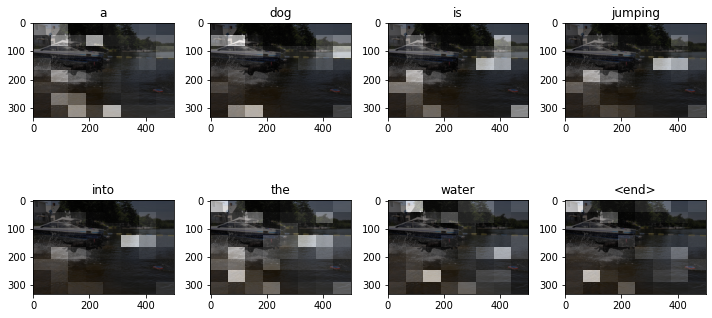

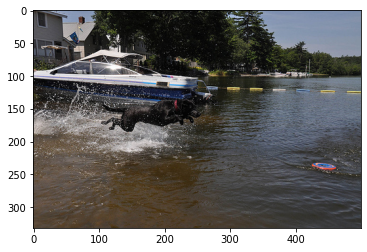

I guess:  a brown dog is jumping into the water


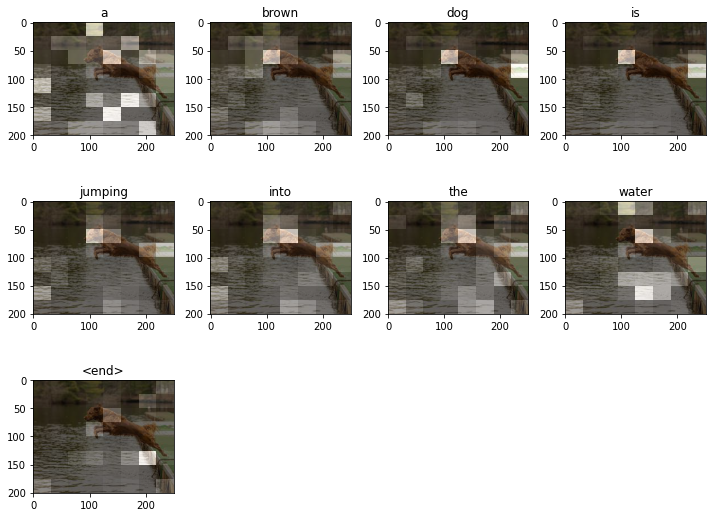

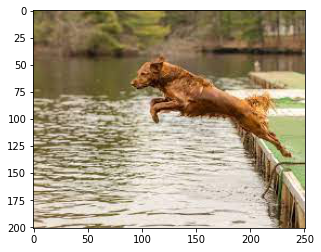

I guess:  a brown and white dog running through a field


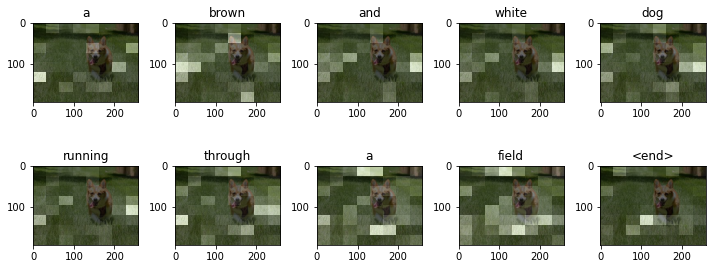

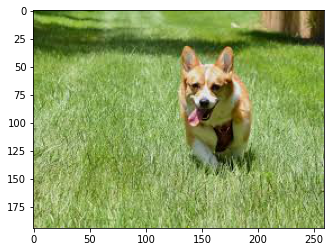

I guess:  a dog runs through a field of leaves


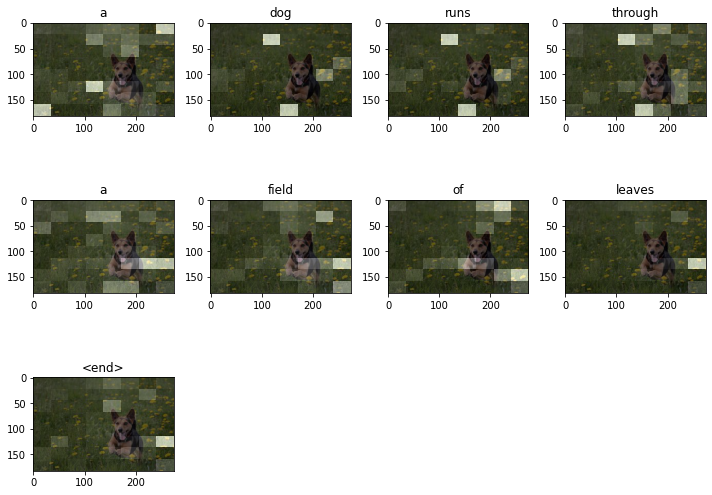

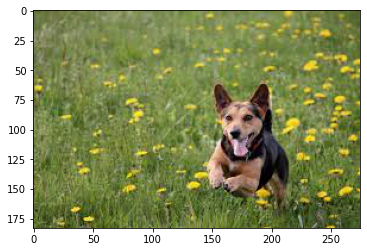

Object  \
GroupSummary   Image                                                       
dog with field /content/drive/MyDrive/Caption_data/flickr8k/do...    dog   
               /content/drive/MyDrive/Caption_data/flickr8k/do...    dog   
dog with water /content/drive/MyDrive/Caption_data/flickr8k/Im...    dog   
               /content/drive/MyDrive/Caption_data/flickr8k/do...    dog   

                                                                   Place  \
GroupSummary   Image                                                       
dog with field /content/drive/MyDrive/Caption_data/flickr8k/do...  field   
               /content/drive/MyDrive/Caption_data/flickr8k/do...  field   
dog with water /content/drive/MyDrive/Caption_data/flickr8k/Im...  water   
               /content/drive/MyDrive/Caption_data/flickr8k/do...  water   

                                                                                                        captions  
GroupSummary   Image                                                                                              
dog with field /content/drive/MyDrive/Caption_data/flickr8k/do...  a brown and white dog running through a field  
               /content/drive/MyDrive/Caption_data/flickr8k/do...           a dog runs through a field of leaves  
dog with water /content/drive/MyDrive/Caption_data/flickr8k/Im...                a dog is jumping into the water  
               /content/drive/MyDrive/Caption_data/flickr8k/do...          a brown dog is jumping into the water

In [47]:
group_imagepredict(list_img)

## How can we make these prediction more accurate:

* This was trained on Flicker 8k dataset, which is a relatively small amount of dataset. We can improve our caption prediction by using large dataset like Microsoft COCO or Flicker 30k dataset.
* We can do some advance technique like data agumentation.
* Insted of VGG16 we can try more complex models Inception model.

# References:
* Tensorflow Tutorials: https://www.tensorflow.org/tutorials/text/image_captioning
* CS231n: Convolutional Neural Networks for Visual Recognition by Andrej Karpathy: https://www.youtube.com/watch?v=NfnWJUyUJYU&list=PLkt2uSq6rBVctENoVBg1TpCC7OQi31AlC
* Show, Attend and Tell: Neural Image Caption
Generation with Visual Attention: https://arxiv.org/pdf/1502.03044.pdf
* Seq to seq model by Andrew Ng: https://www.youtube.com/watch?v=Q8ys8YnDRXM&list=PL1w8k37X_6L_s4ncq-swTBvKDWnRSrinI
* Attention Is All You Need: https://arxiv.org/pdf/1706.03762v5.pdf

* Show, Attend and Tell Paper presentation: https://www.youtube.com/watch?v=ENVGHs3yw7k&t=454s

* https://distill.pub/2016/augmented-rnns/
* https://fairyonice.github.io/Develop_an_image_captioning_deep_learning_model_using_Flickr_8K_data.html#Add-start-and-end-sequence-tokens

* BLEU score: https://machinelearningmastery.com/calculate-bleu-score-for-text-python/